In [1]:
import sys
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parents[1] 
sys.path.append(str(ROOT / "src"))

df = pd.read_csv("../../data/wineQT.csv")

In [20]:
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from gdLinear import GDLinearReg

# features = alle kolonner unntatt target og Id
X = df.drop(columns=["quality", "Id"]).values
y = df["quality"].values

# standardiser X
X = (X - X.mean(axis=0)) / X.std(axis=0)

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

results_multi = []
preds_multi = []

for fold, (train_idx, test_idx) in enumerate(cv.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = GDLinearReg(lr=0.01, n_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results_multi.append({"fold": fold+1, "MSE": mse, "RMSE": rmse, "R2": r2})
    preds_multi.extend(
        {"fold": fold+1, "y_test": float(t), "y_pred": float(p)}
        for t, p in zip(y_test, y_pred)
    )

results_multi_df = pd.DataFrame(results_multi)
preds_multi_df = pd.DataFrame(preds_multi, columns=["fold", "y_test", "y_pred"])
print(results_multi_df)
print("Mean:\n", results_multi_df.mean(numeric_only=True))
print("Variance:\n", results_multi_df.var(numeric_only=True))

results_multi_df.to_csv("../outputs/metrics/multipleFeaturesGDResults.csv", index=False)
preds_multi_df.to_csv("../outputs/metrics/multipleFeaturesGDPreds.csv", index=False)


   fold       MSE      RMSE        R2
0     1  0.380034  0.616469  0.317066
1     2  0.459056  0.677537  0.303433
2     3  0.508919  0.713386  0.278150
3     4  0.412722  0.642435  0.301956
4     5  0.441733  0.664630  0.460100
Mean:
 fold    3.000000
MSE     0.440493
RMSE    0.662891
R2      0.332141
dtype: float64
Variance:
 fold    2.500000
MSE     0.002364
RMSE    0.001335
R2      0.005313
dtype: float64


Evaluation of the model that used all the features:
Mean MSE: ~0.44, RMSE: ~0.66, R²: ~0.33
Variance of MSE, RMSE, R² are all low, indicating consistent performance across folds.
Using all features significantly improves performance compared to single-feature models.
The model explains about 33% of the variance in wine quality, showing that multiple features together provide a much better prediction.
In comparison, the single-feature models had much lower R² values (0.19 for alcohol and 0.02 for chlorides), indicating they captured far less of the variation in quality.

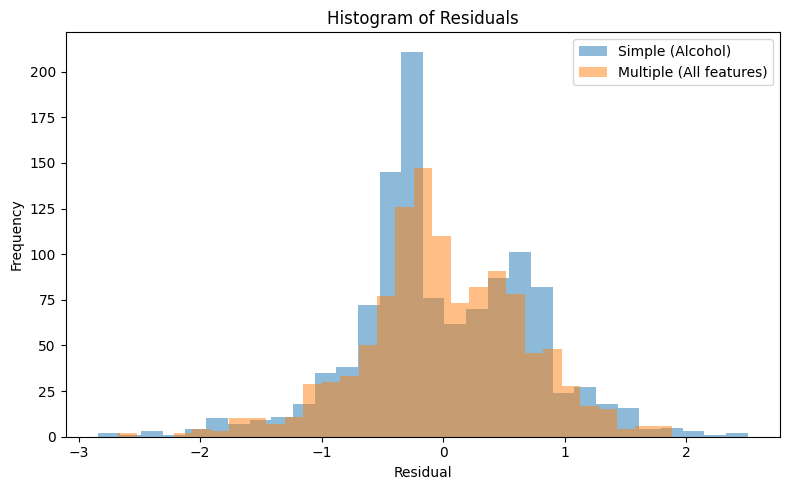

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# === Load predictions ===
preds_alc  = pd.read_csv("../outputs/metrics/alcoholGDPreds.csv")
preds_mult = pd.read_csv("../outputs/metrics/multipleFeaturesGDPreds.csv")

# Legg til residuals
preds_alc["residual"] = preds_alc["y_test"] - preds_alc["y_pred"]
preds_mult["residual"] = preds_mult["y_test"] - preds_mult["y_pred"]

plt.figure(figsize=(8,5))
plt.hist(preds_alc["residual"], bins=30, alpha=0.5, label="Simple (Alcohol)")
plt.hist(preds_mult["residual"], bins=30, alpha=0.5, label="Multiple (All features)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/residualsAlcoholVsMultipleModels.png", bbox_inches="tight")
plt.show()

The multiple regression model performs better than the simple regression model with alcohol as the only predictor. This is evident from several evaluation metrics:
Lower MSE and RMSE: The multiple regression model consistently achieves lower error values across folds, meaning its predictions are closer to the true wine quality scores.
Higher R²: Multiple regression explains a larger proportion of the variance in wine quality compared to alcohol alone, showing that additional features improve predictive power.
Residual distribution: In the histogram, the residuals of the multiple features regression model are more tightly centered around zero and show less spread compared to the simple regression model. 
This indicates that the multiple regression model makes fewer large errors and is more accurate overall.